In [1]:
import os
import pprint
from dotenv import load_dotenv
## langsmith
from langsmith import Client
from langchain_teddynote import logging
## OpenAI
from langchain_openai import ChatOpenAI
from langchain.schema import ChatMessage, AIMessage, HumanMessage, SystemMessage
from langchain.embeddings.openai import OpenAIEmbeddings
## ChromaDB
import chromadb
from langchain.vectorstores import Chroma
## History
from operator import itemgetter
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_community.chat_message_histories import ChatMessageHistory, StreamlitChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
## LangGraph
from typing import TypedDict
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import GraphRecursionError
from langchain_community.tools.tavily_search import TavilySearchResults
## Google Search
from langchain_google_community import GoogleSearchAPIWrapper
from langchain_core.tools import Tool

In [2]:
# .env 파일 활성화 & API KEY 설정
load_dotenv()
openai_api_key = os.getenv('OPENAI_API_KEY')

logging.langsmith("240731") 

LangSmith 추적을 시작합니다.
[프로젝트명]
240731


# Graph State

In [3]:
##############################################################################################################
################################################GraphState####################################################
##############################################################################################################
# GraphState 상태를 저장하는 용도
class GraphState(TypedDict):
    question: str  # 질문
    q_type: str # 질문의 유형
    context: str  # 문서의 검색 결과
    answer: str  # llm이 생성한 답변
    relevance: str  # 답변의 문서에 대한 관련성 (groundness check)

# Model

In [4]:
store = {}

# 세션 ID를 기반으로 세션 기록을 가져오는 함수
def get_session_history(session_ids):
    if session_ids not in store:  # 세션 ID가 store에 없는 경우
        # 새로운 ChatMessageHistory 객체를 생성하여 store에 저장
        store[session_ids] = ChatMessageHistory()
    return store[session_ids]  # 해당 세션 ID에 대한 세션 기록 반환

## m1: Descision maker

In [23]:
##############################################################################################################
################################################Decision Maker ###############################################
##############################################################################################################

def decision_maker(state: GraphState) -> GraphState:
    chat = ChatOpenAI(model="gpt-4o", api_key=openai_api_key)
    
    prompt = PromptTemplate.from_template(
         """
            너는 question의 종류를 분류하는 모델이야. 질문의 종류는 ['주소관련 질문', '검색필요 질문', '일반 질문'] 3가지 종류로 구분 돼. 이때 question뿐만 아니라 chat_history까지 고려해줘.
            
            1. 주소관련 질문: 주소(address)와 관련된 질문을 의미해. 예를 들어, 주소와 관련된 개념, 정의, 주소관련 데이터 분석 등과 같은 내용의 질문일 경우 '주소관련 질문'으로 분류해 줘.
            2. 검색필요 질문: 주소(address)와 관련되지 않은 질문 중, 너가 스스로 대답할 수 없는 질문을 의미해. 예를 들어, '오늘의 날씨', '오늘의 주가' 등과 같이 최신 정보를 반영해야 하는 경우와 '~검색해줘'라는 말이 포함될 때 '검색필요 질문'으로 분류해 줘.
            3. 일반 질문: 주소(address)와 관련되지 않은 질문 중, 너가 스스로 대답할 수 있는 질문을 의미해. 예를 들어, '영어를 한국어로 번역해줘', '대한민국의 수도는?'과 같이 일반 상식적인 질문인 경우 '일반 질문'으로 분류해 줘.
            
            질문이 들어왔을 때, 위 3개의 종류 중에 가장 해당되는 분류를 선택하고 반드시 ['주소관련 질문', '검색필요 질문', '일반 질문'] 중 하나로 선택해. 띄어쓰기나 대소문자 구분 등 다른 형식이나 추가적인 설명 없이 오직 하나의 라벨만 출력해줘.

            #Previous Chat History:
            {chat_history}

            #Question: 
            {question} 
            #Answer:"""
            )
    
    chain = prompt | chat | StrOutputParser()
    
    rag_with_history = RunnableWithMessageHistory(
        chain,
        get_session_history,  # 세션 기록을 가져오는 함수
        input_messages_key="question",  # 사용자의 질문이 템플릿 변수에 들어갈 key
        history_messages_key="chat_history",  # 기록 메시지의 키
    )
    
    input_data = {
        'question': state["question"],
        'chat_history': itemgetter("chat_history"),
        'context':''
    }
    
    response = rag_with_history.invoke(input_data, config={"configurable": {"session_id": "rag123"}})
    return GraphState(
        q_type=response,
        question=state["question"],
    )

def decision_making(state: GraphState) -> GraphState:
    q_type_strip = state["q_type"].strip()
    if q_type_strip == "주소관련 질문":
        return "about_address"
    elif q_type_strip == "검색필요 질문":
        return "search"
    elif q_type_strip == "일반 질문":
        return "general"

In [8]:
# def decision_maker(query):
#     messages = decision_message(query)
#     response = chat.invoke(messages)
#     return response.content

# decision_maker('주소와 주소정보의 차이는?')

'주소관련 질문'

In [9]:
# decision_maker('내일 서울의 기온은 어떨까?')

'검색필요 질문'

In [10]:
# decision_maker('hi')

'일반 질문'

## m2: Groundness checker

In [6]:
##############################################################################################################
################################################Groundness Checker ###########################################
##############################################################################################################

chat = ChatOpenAI(model="gpt-4o", api_key=openai_api_key)

def relevance_message(context, question):
    
    messages = [
        SystemMessage(content="""
            너는 Query와 Document를 비교해서 ['grounded', 'notGrounded', 'notSure'] 셋 중 하나의 라벨을 출력하는 모델이야.

            'grounded': Compare the Query and the Document. If the Document includes content that can be used to generate an answer to the Query, output the label 'grounded'.
            'notGrounded': Compare the Query and the Document. If the Document does not include content that can be used to generate an answer to the Query, or if the information is insufficient, output the label ‘notGrounded’.
            'notSure': Compare the Query and the Document. If you cannot determine whether the Document includes content that can be used to generate an answer to the Query, output the label .notSure'.
            
            너의 출력은 반드시 'grounded', 'notGrounded', 'notSure' 중 하나여야 해. 띄어쓰기나 대소문자 구분 등 다른 형식이나 추가적인 설명 없이 오직 하나의 라벨만 출력해줘.
        """),
        HumanMessage(content=f"""
            [Document]
            {context}

            [Query]
            {question}
        """),
    ]
    return messages

def relevance_check(state: GraphState) -> GraphState:
    messages = relevance_message(state["context"], state["question"])
    print(messages)
    print(state['context'])
    
    response = chat.invoke(messages)
    return GraphState(
        relevance=response.content,
        context=state["context"],
        answer=state["answer"],
        question=state["question"],
    )

def is_relevant(state: GraphState) -> GraphState:
    relevance_strip = state["relevance"].strip()
    if relevance_strip == "grounded":
        return "grounded"
    elif relevance_strip == "notGrounded":
        return "notGrounded"
    elif relevance_strip == "notSure":
        return "notSure"

## m3: Answer maker

In [7]:
##############################################################################################################
################################################LLM Answer Maker##############################################
##############################################################################################################

def llm_answer(state: GraphState) -> GraphState:
    
    # 프롬프트를 생성합니다.
    prompt = PromptTemplate.from_template(
        """
                너는 Context의 정보를 반드시 활용해서 답변을 생성하는 챗봇이야. 
                이때, 답변은 Context에 정보가 있을 수도 있고, 없을 수도 있어. 
                Context의 정보로 답변을 생성할 수 있는 경우 해당 정보를 활용하고, 만약 Context의 정보로 답변을 유추조차 할 수 없는 경우, Context를 참고하지 말고 그냥 너가 생각한 답변을 생성해줘.
                주소와 관련된 질문인 경우 최대한 Context의 답변을 기반을 참고해주고, 그렇지 않은 경우 그냥 너의 지식을 활용해줘.
                답변에는 Context라는 단어를 사용하지 말아줘.

                #Previous Chat History:
                {chat_history}

                #Question: 
                {question} 

                #Context: 
                {context} 

                #Answer:
                
            """
                )

    llm = ChatOpenAI(model_name="gpt-4o", temperature=0)
    
    # 프롬프트, 모델, 출력 파서를 체이닝합니다.
    chain = prompt | llm | StrOutputParser()

    # 대화를 기록하는 RAG 체인 생성
    rag_with_history = RunnableWithMessageHistory(
        chain,
        get_session_history,  # 세션 기록을 가져오는 함수
        input_messages_key="question",  # 사용자의 질문이 템플릿 변수에 들어갈 key
        history_messages_key="chat_history",  # 기록 메시지의 키
    )
    
    # 상태에서 질문과 대화 기록을 가져옵니다.
    input_data = {
        'question': state["question"],
        'chat_history': itemgetter("chat_history"),
        'context': state["context"]
    }

    response = rag_with_history.invoke(input_data, config={"configurable": {"session_id": "rag123"}})
    
    return GraphState(
        answer=response,
        context=state["context"],
        question=state["question"],
    )

## m4: General answer maker

In [8]:
##############################################################################################################
################################################LLM Answer Maker##############################################
##############################################################################################################

def general_llm(state: GraphState) -> GraphState:
    
    # 프롬프트를 생성합니다.
    prompt = PromptTemplate.from_template(
        """     
                너는 일반적인 상식과 정보에 대해서 답변하는 챗봇이야. chat_hisotry에 값이 있는 경우 그 값을 참고해서 답변을 해줘.

                #Previous Chat History:
                {chat_history}

                #Question: 
                {question} 
                
                #Answer:
                
            """
                )

    llm = ChatOpenAI(model_name="gpt-4o", temperature=0)
    
    # 프롬프트, 모델, 출력 파서를 체이닝합니다.
    chain = prompt | llm | StrOutputParser()

    # 대화를 기록하는 RAG 체인 생성
    rag_with_history = RunnableWithMessageHistory(
        chain,
        get_session_history,  # 세션 기록을 가져오는 함수
        input_messages_key="question",  # 사용자의 질문이 템플릿 변수에 들어갈 key
        history_messages_key="chat_history",  # 기록 메시지의 키
    )
    
    # 상태에서 질문과 대화 기록을 가져옵니다.
    input_data = {
        'question': state["question"],
        'chat_history': itemgetter("chat_history"),
    }

    response = rag_with_history.invoke(input_data, config={"configurable": {"session_id": "rag123"}})
    
    return GraphState(
        answer=response,
        question=state["question"],
    )

# Retrieve

In [10]:
##############################################################################################################
################################################Retriever#####################################################
##############################################################################################################
class MultiCollectionRetriever:
    def __init__(self, client, collection_names, embedding_function, search_kwargs={"k": 2}):
        self.collections = [
            Chroma(client=client, collection_name=name, embedding_function=embedding_function)
            for name in collection_names
        ]
        self.search_kwargs = search_kwargs

    def retrieve(self, query):
        results = []
        for collection in self.collections:
            # 각 컬렉션에서 유사도 검색 수행
            documents_with_scores = collection.similarity_search_with_score(query, **self.search_kwargs)
            results.extend(documents_with_scores)
        
        # 유사도 점수를 기준으로 결과 정렬 (score가 높을수록 유사도가 높음)
        results.sort(key=lambda x: x[1], reverse=False)

        documents = [(doc, score) for doc, score in results]
        return documents

# 사용 예시
client = chromadb.PersistentClient('../juso-chat-bot-v0.1/chroma/')
collection_names = ["csv_files_openai_3072", "49_files_openai_3072"]
embedding = OpenAIEmbeddings(model='text-embedding-3-large') 
multi_retriever = MultiCollectionRetriever(client, collection_names, embedding)

/Users/jeongyunl/opt/anaconda3/envs/juso-chatbot/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(
/Users/jeongyunl/opt/anaconda3/envs/juso-chatbot/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 0.4. An updated version of the class exists in the langchain-chroma package and should be used instead. To use it run `pip install -U langchain-chroma` and import as `from langchain_chroma import Chroma`.
  warn_deprecated(


In [11]:
##############################################################################################################
################################################vector Retriever##############################################
##############################################################################################################
def retrieve_document(state: GraphState) -> GraphState:
    # Question 에 대한 문서 검색을 retriever 로 수행합니다.
    retrieved_docs = multi_retriever.retrieve(state["question"])
    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(context=retrieved_docs[:2])

# Search (Tavily)

In [12]:
##############################################################################################################
################################################Search on Web ################################################
##############################################################################################################  
    
def search_on_web(state: GraphState) -> GraphState:
    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    search_tool = TavilySearchResults(max_results=5)
    search_result = search_tool.invoke({"query": state["question"]})

    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(
        context=search_result,
    )

# Related Graph Nodes

In [13]:
##############################################################################################################
################################################Setting Graph Relations#######################################
##############################################################################################################

workflow = StateGraph(GraphState)

# 노드들을 정의합니다.
workflow.add_node("decision_maker", decision_maker)  # 질문의 종류를 분류하는 노드를 추가합니다.
workflow.add_node("retrieve", retrieve_document)  # 답변을 검색해오는 노드를 추가합니다.
workflow.add_node("general_llm", general_llm)  # 일반 질문에 대한 답변을 생성하는 노드를 추가합니다.
workflow.add_node("relevance_check", relevance_check)  # 답변의 문서에 대한 관련성 체크 노드를 추가합니다.
workflow.add_node("search_on_web", search_on_web)  # 웹 검색 노드를 추가합니다.
workflow.add_node("llm_answer", llm_answer)  # 답변을 생성하는 노드를 추가합니다.

workflow.add_edge("retrieve", "relevance_check")  # 검색 -> 답변
workflow.add_edge("search_on_web", "relevance_check")  # 웹 검색 -> 답변

# 조건부 엣지를 추가합니다.
workflow.add_conditional_edges(
    "decision_maker",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    decision_making,
    {
        "about_address": "retrieve",  # 관련성이 있으면 종료합니다.
        "search": "search_on_web",  # 관련성이 없으면 다시 질문을 작성합니다.
        "general": "general_llm",  # 관련성 체크 결과가 모호하다면 다시 질문을 작성합니다.
    },
)

# 조건부 엣지를 추가합니다.
workflow.add_conditional_edges(
    "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    is_relevant,
    {
        "grounded": "llm_answer",  # 관련성이 있으면 종료합니다.
        "notGrounded": "search_on_web",  # 관련성이 없으면 다시 질문을 작성합니다.
        "notSure": "search_on_web",  # 관련성 체크 결과가 모호하다면 다시 질문을 작성합니다.
    },
)

workflow.add_edge("llm_answer", END)  # 답변 -> 종료
workflow.add_edge("general_llm", END)  # 답변 -> 종료

# 시작점을 설정합니다.
workflow.set_entry_point("decision_maker")

# 기록을 위한 메모리 저장소를 설정합니다.
memory = MemorySaver()

# 그래프를 컴파일합니다.
app = workflow.compile(checkpointer=memory)

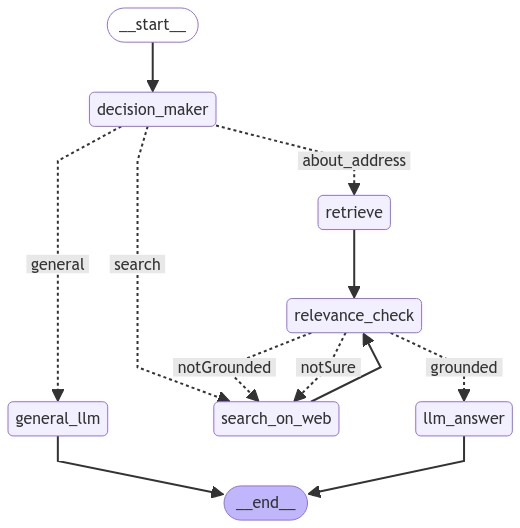

In [14]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

In [15]:
def stream_responses(question):
    config = RunnableConfig(
        recursion_limit=20, configurable={"thread_id": "CORRECTIVE-SEARCH-RAG"}
    )

    # AgentState 객체를 활용하여 질문을 입력합니다.
    inputs = GraphState(
        question=question
    )

    # app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.   
    try:
        output_generator = app.invoke(inputs, config=config)
        return output_generator
    except GraphRecursionError as e:
        # 예외 발생 시 반환값을 명확히 설정합니다.
        return pprint.pprint(f"Recursion limit reached: {e}")

In [16]:
result = stream_responses('건축물대장과 관련된 데이터는 뭐가 있니?')
result

Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')


[SystemMessage(content="\n            너는 Query와 Document를 비교해서 ['grounded', 'notGrounded', 'notSure'] 셋 중 하나의 라벨을 출력하는 모델이야.\n\n            'grounded': Compare the Query and the Document. If the Document includes content that can be used to generate an answer to the Query, output the label 'grounded'.\n            'notGrounded': Compare the Query and the Document. If the Document not includes content that can be used to generate an answer to the Query, output the label 'notGrounded'.\n            'notSure': Compare the Query and the Document. If you cannot determine whether the Document includes content that can be used to generate an answer to the Query, output the label .notSure'.\n            \n            너의 출력은 반드시 'grounded', 'notGrounded', 'notSure' 중 하나여야 해. 띄어쓰기나 대소문자 구분 등 다른 형식이나 추가적인 설명 없이 오직 하나의 라벨만 출력해줘.\n        "), HumanMessage(content="\n            [Document]\n            [(Document(metadata={'source': 'data/final/chapter-3-3.md'}, page_content='건축물대장 상세주소 (전체분) 예시'), 

Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')


{'question': '건축물대장과 관련된 데이터는 뭐가 있니?',
 'q_type': '주소관련 질문',
 'context': [(Document(metadata={'source': 'data/final/chapter-3-3.md'}, page_content='건축물대장 상세주소 (전체분) 예시'),
   0.7328253388404846),
  (Document(metadata={'source': 'data/final/chapter-2-3.md'}, page_content='건축물대장 상세주소 (전체분) 예시'),
   0.7332523465156555)],
 'answer': '건축물대장과 관련된 데이터에는 다음과 같은 정보들이 포함될 수 있습니다:\n\n1. 건축물의 상세주소\n2. 건축물의 용도\n3. 건축물의 구조\n4. 건축물의 층수\n5. 건축물의 면적\n6. 건축물의 건축 연도\n7. 건축물의 소유자 정보\n8. 건축물의 사용 승인일\n\n이 외에도 건축물의 상태나 변경 이력 등 다양한 정보가 포함될 수 있습니다.',
 'relevance': 'grounded'}

In [17]:
store

{'rag123': InMemoryChatMessageHistory(messages=[HumanMessage(content='건축물대장과 관련된 데이터는 뭐가 있니?'), AIMessage(content='주소관련 질문'), HumanMessage(content='건축물대장과 관련된 데이터는 뭐가 있니?'), AIMessage(content='건축물대장과 관련된 데이터에는 다음과 같은 정보들이 포함될 수 있습니다:\n\n1. 건축물의 상세주소\n2. 건축물의 용도\n3. 건축물의 구조\n4. 건축물의 층수\n5. 건축물의 면적\n6. 건축물의 소유자 정보\n7. 건축물의 건축 연도\n8. 건축물의 대지 면적\n\n이 외에도 건축물의 상태, 사용 승인일, 건축물의 변경 이력 등 다양한 정보가 포함될 수 있습니다.')])}

In [17]:
stream_responses('위 답변을 영어로 작성해줘')

Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')


{'question': '위 답변을 영어로 작성해줘',
 'q_type': '일반 질문',
 'context': [[Document(metadata={'source': 'data/final/chapter-3-3.md'}, page_content='건축물대장 상세주소 (전체분) 예시'),
   0.7328253388404846],
  [Document(metadata={'source': 'data/final/chapter-2-3.md'}, page_content='건축물대장 상세주소 (전체분) 예시'),
   0.7332523465156555]],
 'answer': 'Sure, here is the translation of the previous answer into English:\n\nThe data related to the building register may include the following information:\n\n1. Detailed address of the building\n2. Purpose of the building\n3. Structure of the building\n4. Number of floors of the building\n5. Area of the building\n6. Year of construction of the building\n7. Owner information of the building\n8. Date of use approval of the building\n\nIn addition, various information such as the condition of the building or its modification history may also be included.',
 'relevance': 'grounded'}

In [19]:
store

{'rag123': InMemoryChatMessageHistory(messages=[HumanMessage(content='건축물대장과 관련된 데이터는 뭐가 있니?'), AIMessage(content='주소관련 질문'), HumanMessage(content='건축물대장과 관련된 데이터는 뭐가 있니?'), AIMessage(content='건축물대장과 관련된 데이터에는 다음과 같은 정보들이 포함될 수 있습니다:\n\n1. 건축물의 상세주소\n2. 건축물의 용도\n3. 건축물의 구조\n4. 건축물의 층수\n5. 건축물의 면적\n6. 건축물의 소유자 정보\n7. 건축물의 건축 연도\n8. 건축물의 대지 면적\n\n이 외에도 건축물의 상태, 사용 승인일, 건축물의 변경 이력 등 다양한 정보가 포함될 수 있습니다.'), HumanMessage(content='위 답변을 영어로 작성해줘'), AIMessage(content='일반 질문'), HumanMessage(content='위 답변을 영어로 작성해줘'), AIMessage(content='Sure, here is the translation of the previous answer into English:\n\nThe data related to the building register may include the following information:\n\n1. Detailed address of the building\n2. Purpose of the building\n3. Structure of the building\n4. Number of floors of the building\n5. Area of the building\n6. Owner information of the building\n7. Year of construction of the building\n8. Land area of the building\n\nIn addition, various information such as the 

In [18]:
result = stream_responses('도로명주소법 4조의 내용은?')
result

Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')


[SystemMessage(content="\n            너는 Query와 Document를 비교해서 ['grounded', 'notGrounded', 'notSure'] 셋 중 하나의 라벨을 출력하는 모델이야.\n\n            'grounded': Compare the Query and the Document. If the Document includes content that can be used to generate an answer to the Query, output the label 'grounded'.\n            'notGrounded': Compare the Query and the Document. If the Document not includes content that can be used to generate an answer to the Query, output the label 'notGrounded'.\n            'notSure': Compare the Query and the Document. If you cannot determine whether the Document includes content that can be used to generate an answer to the Query, output the label .notSure'.\n            \n            너의 출력은 반드시 'grounded', 'notGrounded', 'notSure' 중 하나여야 해. 띄어쓰기나 대소문자 구분 등 다른 형식이나 추가적인 설명 없이 오직 하나의 라벨만 출력해줘.\n        "), HumanMessage(content="\n            [Document]\n            [(Document(metadata={'source': 'data/final/[1018] 주소정보_업무편람_최종(하이퍼링크).docx'}, page_content='3) 우편법

Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')


{'question': '도로명주소법 4조의 내용은?',
 'q_type': '주소관련 질문',
 'context': [{'url': 'http://www.yeslaw.com/lims/front/page/fulltext.html?action=LAW&lawid=4207',
   'content': '③ 제1항 및 제2항에 따른 지원의 세부 내용은 대통령령으로 정한다. ... 10조제1항의 개정규정에 따라 부여된 명예도로명으로 본다. ② 이 법 시행 당시 종전의 제8조의2제2항에 따라 도로명주소안내시설에 ... 제49조제4항제3호 중 "「도로명주소법」 제2조제5호의 ...'},
  {'url': 'http://www.yeslaw.co.kr/lims/front/page/fulltext.html?pAct=view&pPromulgationNo=149050',
   'content': '도로명주소법 . ... 제8조의4(도로명주소안내시설의 설치) ... 이 경우 통보된 내용은 제8조제4항의 개정규정에 따른 결정사항으로 본다. 부칙 2009ㆍ6ㆍ9 법9774> 제1조 (시행일) 이 법은 공포 후 6개월이 경과한 날부터 시행한다.'},
  {'url': 'https://www.ulex.co.kr/법률/223451-010300-도로명주소법',
   'content': '도로명주소법. [시행 2021. 6. 9.] [법률 제17574호, 2020.12. 8., 전부개정] 제1조 (목적) 이 법은 도로명주소, 국가기초구역, 국가지점번호 및 사물주소의 표기·사용·관리·활용 등에 관한 사항을 규정함으로써 국민의 생활안전과 편의를 도모하고 관련 산업의 지원을 ...'},
  {'url': 'http://www.yeslaw.com/lims/front/page/fulltext.html?action=LAW&lawid=4207&jo_s=000806&jo_e=',
   'content': '도로명주소법. (시행일자 : 2021-06-09) - 전부개정 -. 제8조 (도로명 등의 변경 및 폐지)

In [19]:
stream_responses('1조의 내용도 알려줘')

Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')


[SystemMessage(content="\n            너는 Query와 Document를 비교해서 ['grounded', 'notGrounded', 'notSure'] 셋 중 하나의 라벨을 출력하는 모델이야.\n\n            'grounded': Compare the Query and the Document. If the Document includes content that can be used to generate an answer to the Query, output the label 'grounded'.\n            'notGrounded': Compare the Query and the Document. If the Document not includes content that can be used to generate an answer to the Query, output the label 'notGrounded'.\n            'notSure': Compare the Query and the Document. If you cannot determine whether the Document includes content that can be used to generate an answer to the Query, output the label .notSure'.\n            \n            너의 출력은 반드시 'grounded', 'notGrounded', 'notSure' 중 하나여야 해. 띄어쓰기나 대소문자 구분 등 다른 형식이나 추가적인 설명 없이 오직 하나의 라벨만 출력해줘.\n        "), HumanMessage(content="\n            [Document]\n            [(Document(metadata={'row': 419, 'source': 'data/csv/주소용어최종정리_1123 - 업데이트_231123.csv'}, page_conte

Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')


{'question': '1조의 내용도 알려줘',
 'q_type': '주소관련 질문',
 'context': [{'url': 'https://www.ilbe.com/view/11543555918',
   'content': '최소 3만원 이내로 좋은거 알려줘 ... 정보통신망에서 불법촬영물등을 유통할 경우 「전기통신사업법」 제22조의5 제1항에 따른 삭제.접속차단 등 유통방지에 필요한 조치가 취해지며 「전기통신사업법」 제11조에 따라 형사처벌을 받을 수 있습니다. + ...'},
  {'url': 'https://ko.wikipedia.org/wiki/대한민국_민법_제1조',
   'content': '황태윤, 민법 제1조와 不文民法의 法源性, 전북대학교 동북아법연구 제6권 제2호 (2012년 9월) pp.143-164. 김경제, 관습법에 대한 오해, 민법 제1조의 헌법 합치적 해석, 세계헌법연구 18권 3호 시작쪽수 1p, 전체쪽수 27p, 2012년. 박철, 민법 제1조의 미학, 법률신문, 2011-06-23'},
  {'url': 'https://ko.wikipedia.org/wiki/대한민국_헌법_제1조',
   'content': '헌법 제1조 제2항은 "대한민국의 주권은 국민에게 있고 모든 권력은 국민으로부터 나온다."고 규정하여 국민주권주의를 천명하고 있다. 이러한 국민주권의 원리 는 일반적으로 어떤 실천적인 의미보다는 국가권력의 정당성이 국민에게 있고 모든 통치권력의 ...'},
  {'url': 'https://moleg.go.kr/knowledge/publication/monthlyPublicationSrch?mpbLegPstSeq=130464',
   'content': '즉, 조의 내용을 작성하면서 여러 가지 요건이나 내용을 다음에 나열할 필요가 있을 때에는 항으로 세분하지 않고 호로 세분하여 조문을 작성하실 수 있습니다. 제9조(결격사유) 다음 각호의 1에 해당하는 자는 제8조의 규정에 의한 대규모점포의 등록을 할 수 ...'},
  

In [22]:
result = stream_responses('hi')
result

Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')


{'question': 'hi',
 'q_type': '일반 질문',
 'context': [{'url': 'https://weather.naver.com/',
   'content': '네이버 날씨는 각 정시 위에 날씨를 표현하나 날씨 요소 별 특성에 따라 구간 또는 정시기준이 다릅니다. 이를 참고해 날씨 데이터를 해석하시기 바랍니다. 13° 기온 : 정시 예) 19시는 19시 정시 기온 ... 오늘의 생활·보건 지수 ...'},
  {'url': 'https://weather.com/ko-KR/weather/today/l/82e46175f97c224acf6b95afc4934fbae0e4ba123adcee8a52b7be97c303467b',
   'content': 'The Weather Channel 및 Weather.com이 제공하는 오늘과 오늘 밤 서울특별시 일기예보, 날씨 상태 및 도플러 레이더'},
  {'url': 'https://www.weather.go.kr/w/weather/now.do',
   'content': '현재. +1H. +3H. 현재날씨 참고사항. - 실황표로 정리되어 있는 기상청 각 지상관측 지점의 시간별 관측 실황자료를 조회하실 수 있습니다. - 해당 자료는 실시간 관측된 자료이며, 현지 사정에 의해 잘못된 값이 표출 될 수 있으므로, 증명자료로 사용 될 수 ...'},
  {'url': 'https://www.weather.go.kr/weather/home/index.jsp',
   'content': '날씨해설. ※ 07월 29일부터 07월 31일까지의 전망입니다. 당분간 전국 대부분 지역에서 최고체감온도가 35도 내외로 올라 매우 무덥겠고 열대야가 나타나는 곳이 많겠습니다. 내일 오후까지 경기북부와 강원내륙.산지를 중심으로 가끔 비가 내리는 곳이 ...'},
  {'url': 'https://www.yna.co.kr/weather/index',
   'content': '날씨 정보 안내 페이지 입니다. 날씨요약 기온 전망

In [20]:
store

{'rag123': InMemoryChatMessageHistory(messages=[HumanMessage(content='건축물대장과 관련된 데이터는 뭐가 있니?'), AIMessage(content='주소관련 질문'), HumanMessage(content='건축물대장과 관련된 데이터는 뭐가 있니?'), AIMessage(content='건축물대장과 관련된 데이터에는 다음과 같은 정보들이 포함될 수 있습니다:\n\n1. 건축물의 상세주소\n2. 건축물의 용도\n3. 건축물의 구조\n4. 건축물의 층수\n5. 건축물의 면적\n6. 건축물의 건축 연도\n7. 건축물의 소유자 정보\n8. 건축물의 사용 승인일\n\n이 외에도 건축물의 상태나 변경 이력 등 다양한 정보가 포함될 수 있습니다.'), HumanMessage(content='위 답변을 영어로 작성해줘'), AIMessage(content='일반 질문'), HumanMessage(content='위 답변을 영어로 작성해줘'), AIMessage(content='Sure, here is the translation of the previous answer into English:\n\nThe data related to the building register may include the following information:\n\n1. Detailed address of the building\n2. Purpose of the building\n3. Structure of the building\n4. Number of floors of the building\n5. Area of the building\n6. Year of construction of the building\n7. Owner information of the building\n8. Date of use approval of the building\n\nIn addition, various information such as the c

In [21]:
result = stream_responses('오늘의 날씨는?')
result

Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')


[SystemMessage(content="\n            너는 Query와 Document를 비교해서 ['grounded', 'notGrounded', 'notSure'] 셋 중 하나의 라벨을 출력하는 모델이야.\n\n            'grounded': Compare the Query and the Document. If the Document includes content that can be used to generate an answer to the Query, output the label 'grounded'.\n            'notGrounded': Compare the Query and the Document. If the Document not includes content that can be used to generate an answer to the Query, output the label 'notGrounded'.\n            'notSure': Compare the Query and the Document. If you cannot determine whether the Document includes content that can be used to generate an answer to the Query, output the label .notSure'.\n            \n            너의 출력은 반드시 'grounded', 'notGrounded', 'notSure' 중 하나여야 해. 띄어쓰기나 대소문자 구분 등 다른 형식이나 추가적인 설명 없이 오직 하나의 라벨만 출력해줘.\n        "), HumanMessage(content="\n            [Document]\n            [{'url': 'https://weather.naver.com/', 'content': '네이버 날씨는 각 정시 위에 날씨를 표현하나 날씨 요소 별 특성에 따라 구간 또는 정

Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')


{'question': '오늘의 날씨는?',
 'q_type': '검색필요 질문',
 'context': [{'url': 'https://weather.naver.com/',
   'content': '네이버 날씨는 각 정시 위에 날씨를 표현하나 날씨 요소 별 특성에 따라 구간 또는 정시기준이 다릅니다. 이를 참고해 날씨 데이터를 해석하시기 바랍니다. 13° 기온 : 정시 예) 19시는 19시 정시 기온 ... 오늘의 생활·보건 지수 ...'},
  {'url': 'https://weather.com/ko-KR/weather/today/l/82e46175f97c224acf6b95afc4934fbae0e4ba123adcee8a52b7be97c303467b',
   'content': 'The Weather Channel 및 Weather.com이 제공하는 오늘과 오늘 밤 서울특별시 일기예보, 날씨 상태 및 도플러 레이더'},
  {'url': 'https://www.weather.go.kr/w/weather/now.do',
   'content': '현재. +1H. +3H. 현재날씨 참고사항. - 실황표로 정리되어 있는 기상청 각 지상관측 지점의 시간별 관측 실황자료를 조회하실 수 있습니다. - 해당 자료는 실시간 관측된 자료이며, 현지 사정에 의해 잘못된 값이 표출 될 수 있으므로, 증명자료로 사용 될 수 ...'},
  {'url': 'https://www.weather.go.kr/weather/home/index.jsp',
   'content': '날씨해설. ※ 07월 29일부터 07월 31일까지의 전망입니다. 당분간 전국 대부분 지역에서 최고체감온도가 35도 내외로 올라 매우 무덥겠고 열대야가 나타나는 곳이 많겠습니다. 내일 오후까지 경기북부와 강원내륙.산지를 중심으로 가끔 비가 내리는 곳이 ...'},
  {'url': 'https://www.yna.co.kr/weather/index',
   'content': '날씨 정보 안내 페이지 입니다. 날씨